In [1]:
from tensorflow import keras
import numpy as np
import pandas as pd
import pickle
import os

from measurement_collector import MeasurementCollector

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
#%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = [15, 15]
    
_db_path = "/home/levcsi/projects/stroke_prediction/data/WUS-v4meresek 20220302.accdb"
_m_path = "/home/levcsi/projects/stroke_prediction/data/biocal.xlsx"
#mc = MeasurementCollector('/home/levcsi/projects/stroke_prediction/data', _db_path, _m_path)

2022-03-31 12:56:21.039388: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/installation/OpenCV-3.4.4/lib/
2022-03-31 12:56:21.039420: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
model = keras.models.load_model('./model_45000_1000000')
model.summary()

2022-03-08 16:23:22.451255: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/installation/OpenCV-3.4.4/lib/
2022-03-08 16:23:22.451283: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-08 16:23:22.451303: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pox): /proc/driver/nvidia/version does not exist
2022-03-08 16:23:22.451531: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 12)]              0         
                                                                 
 hiddel_layer_2 (Dense)      (None, 256)               3328      
                                                                 
 hiddel_layer_3 (Dense)      (None, 128)               32896     
                                                                 
 prediction (Dense)          (None, 6)                 774       
                                                                 
Total params: 36,998
Trainable params: 36,998
Non-trainable params: 0
_________________________________________________________________


In [3]:
keys_in_order = (("arm", "acc"),
                 ("leg", "acc"),
                 ("arm", "gyr"),
                 ("leg", "gyr"))
length = 25 * 60 * 30
step_size = 500

cur_meas_name = None
result_dict = dict()

for mean_dict, class_value, meas_name in mc.sweep_mean_with_class_generator(mean_type='all', length=length,
                                                                            step_size=step_size):
    if cur_meas_name != meas_name:
        print(meas_name)
        result_dict[meas_name] = {
            "class_value": class_value,
            "y_pred_list": list()
        }
        cur_meas_name = meas_name

    instance = list()
    for key in keys_in_order:
        instance.append(mean_dict[key])
    instance = sum(instance, [])
    
    y_pred = model.predict([instance])
    result_dict[meas_name]["y_pred_list"].append(y_pred[0])

202110230
202110251
202110280
202111021
202111041
202111141
202111181
202112020
202112131
202112171
202201061
202201191


## Save results

In [4]:
pickle.dump(result_dict, open("./result_dict_{}_{}.pkl".format(length, step_size), "wb"))

## Load results

In [2]:
result_dict = pickle.load(open("./result_dict_90000_500.pkl", "rb"))

202110230
class value: 5


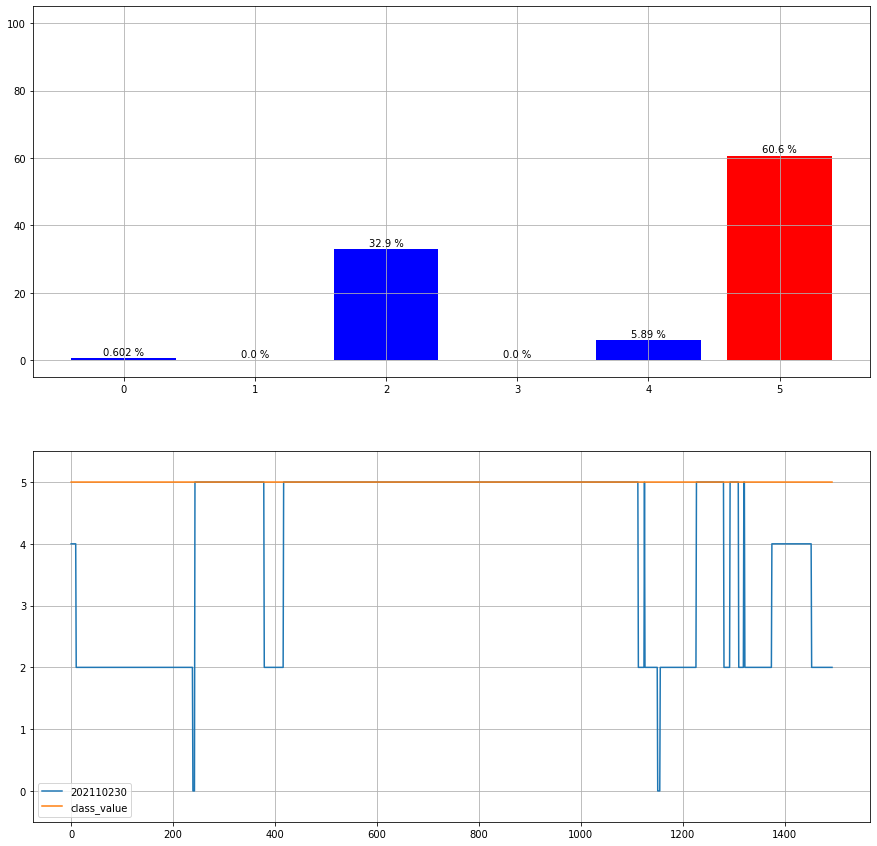

202110251
class value: 2


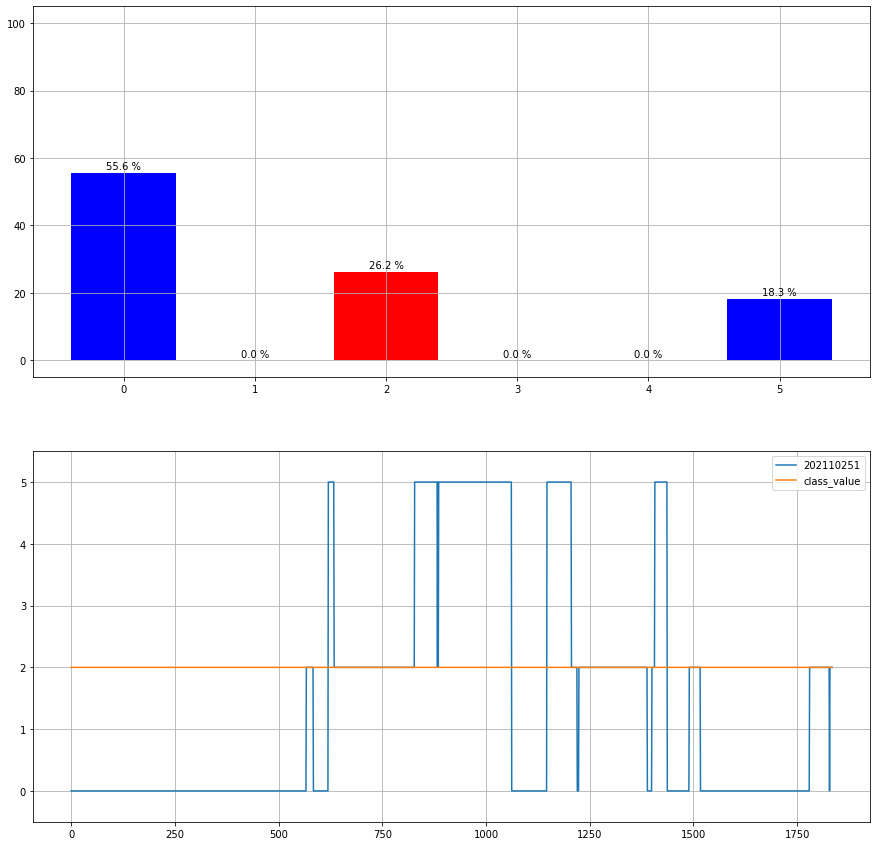

202110280
class value: 0


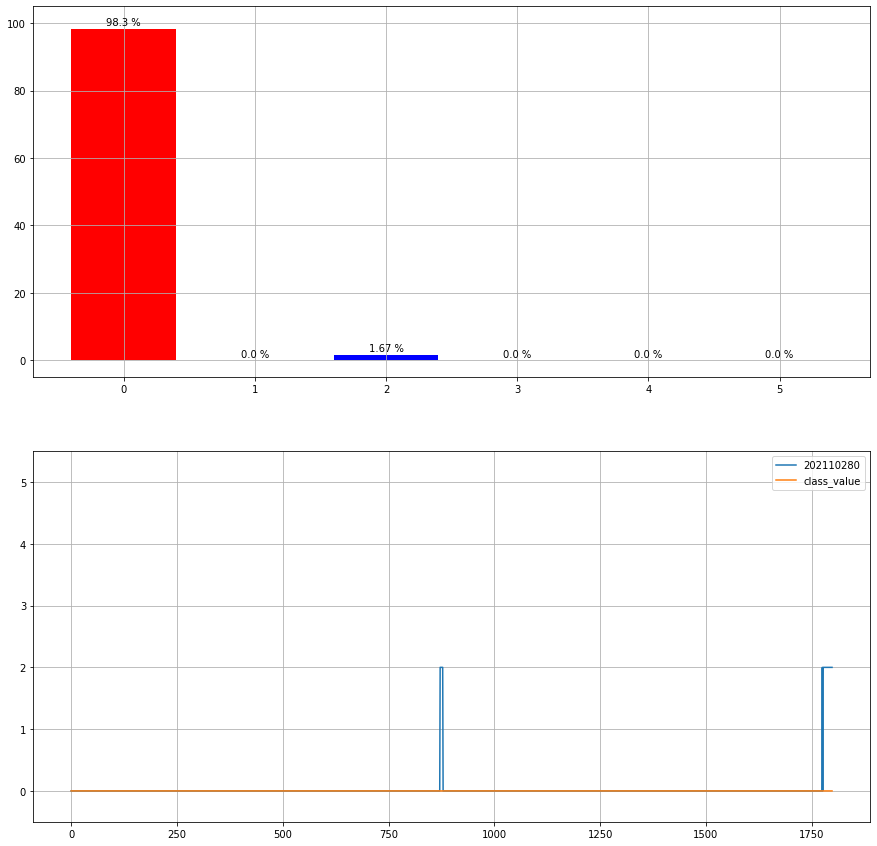

202111021
class value: 2


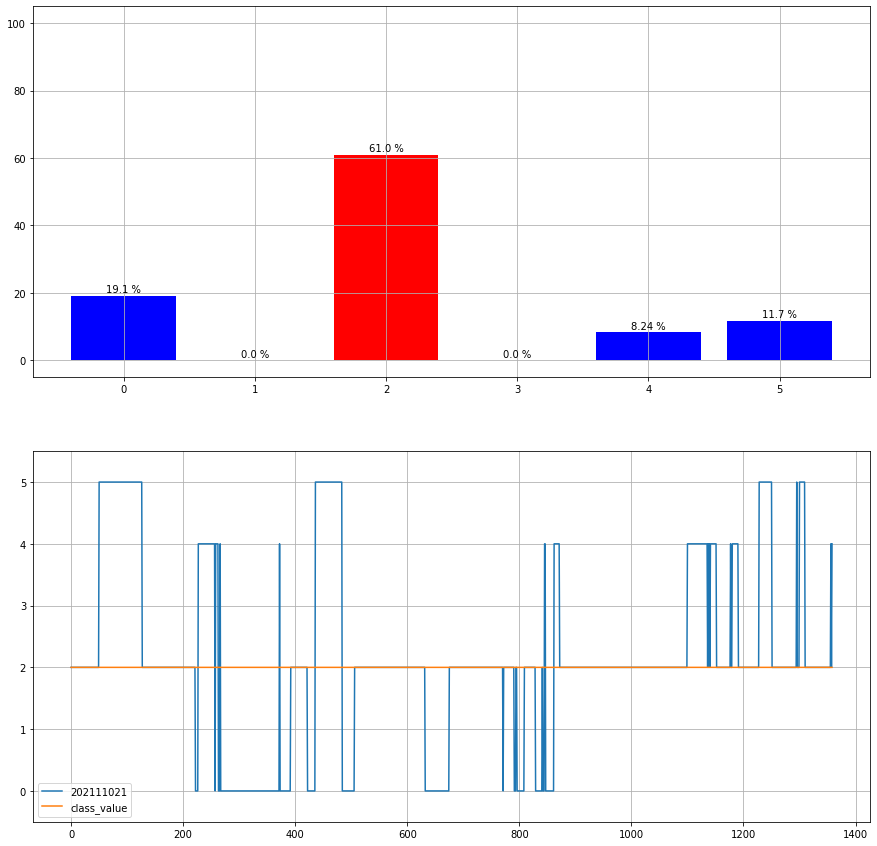

202111041
class value: 0


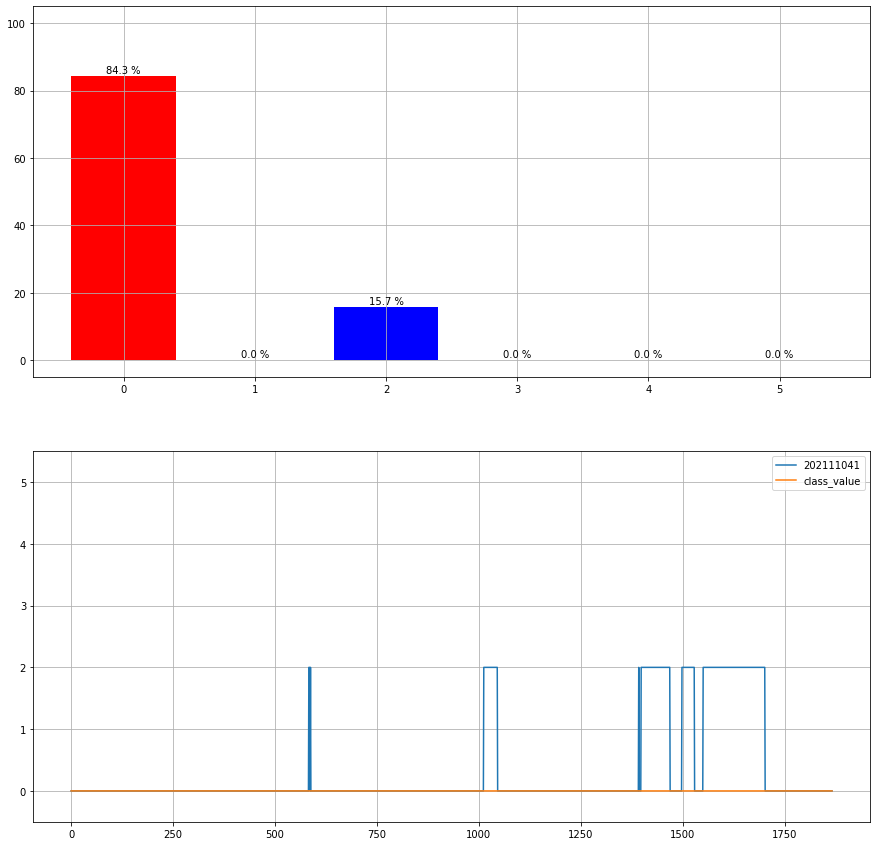

202111141
class value: 5


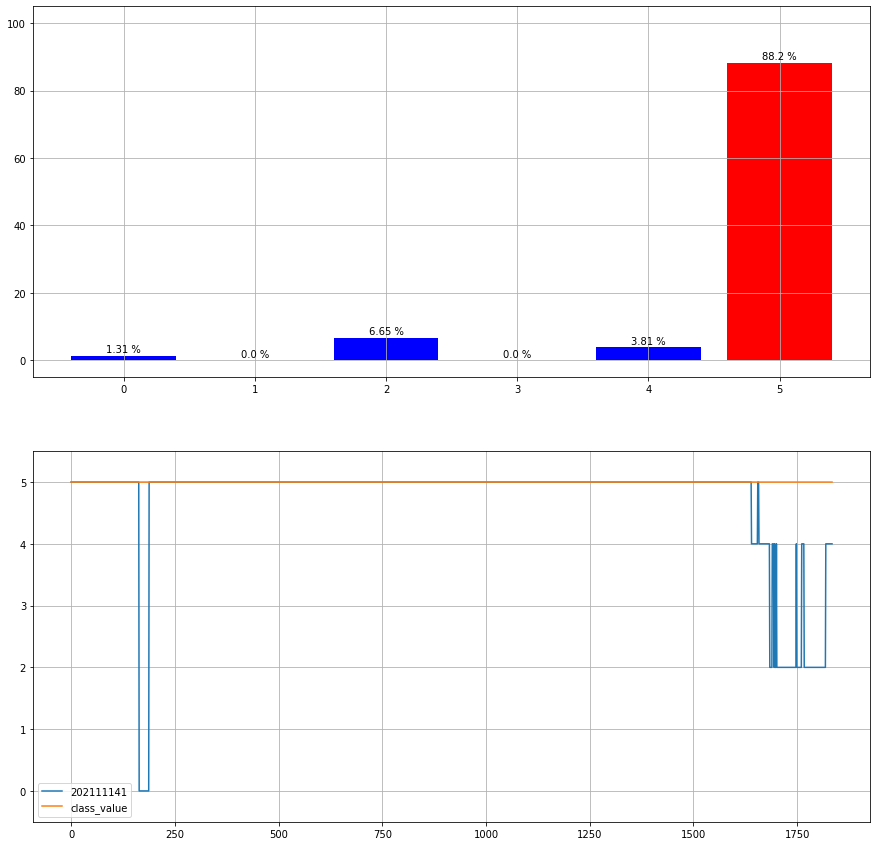

202111181
class value: 0


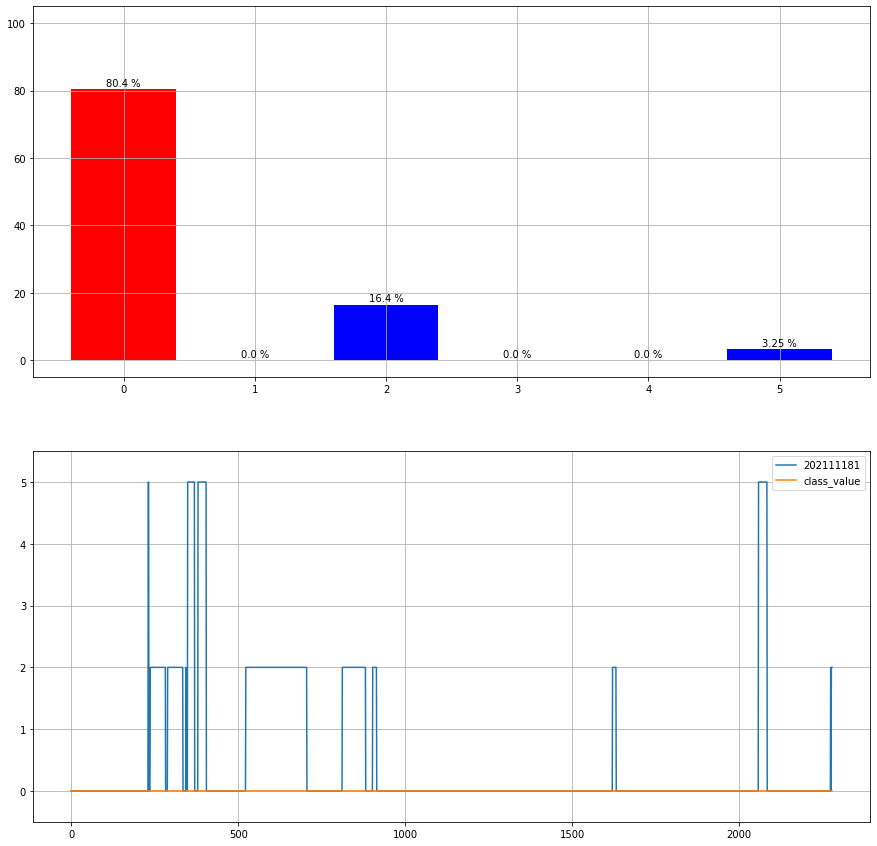

202112020
class value: 5


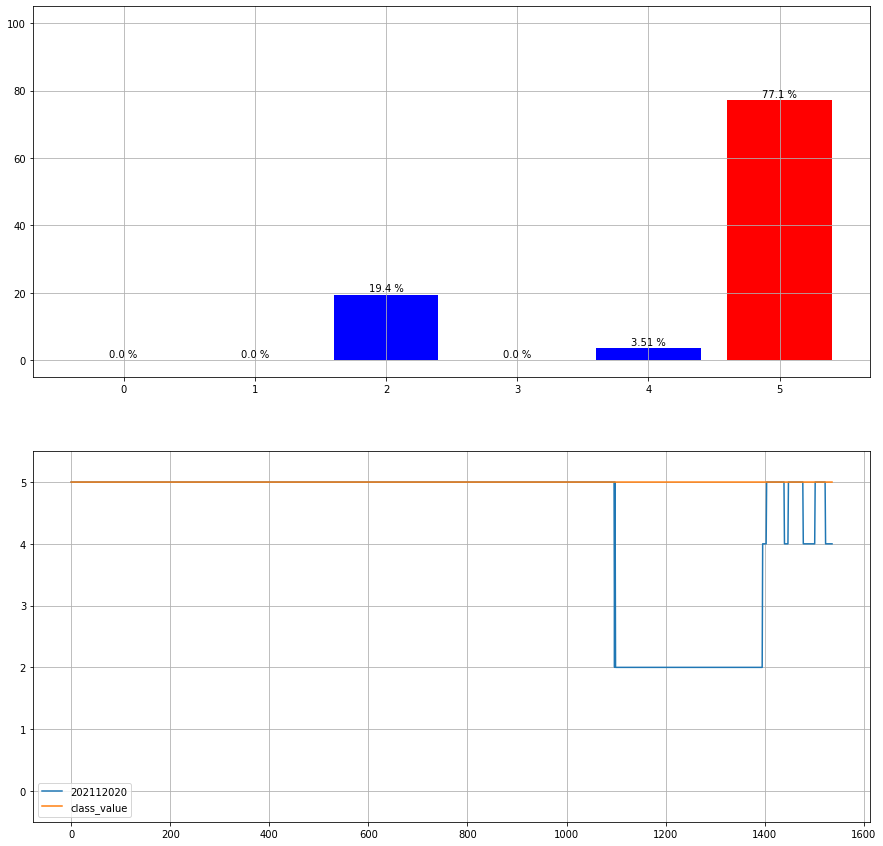

202112131
class value: 2


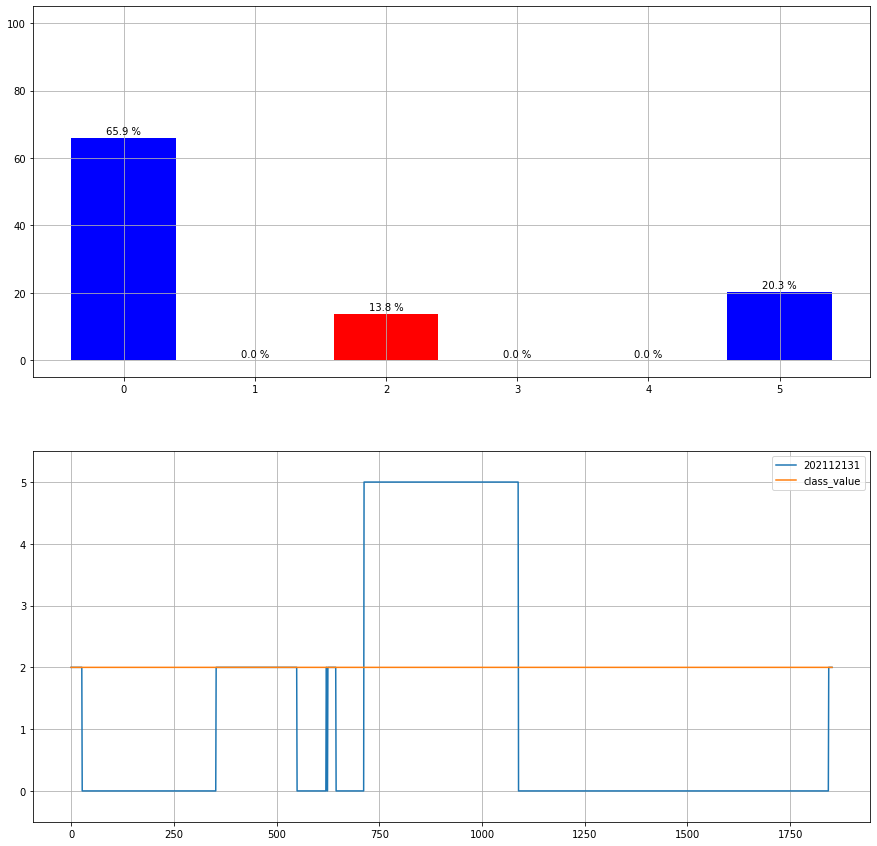

202112171
class value: 2


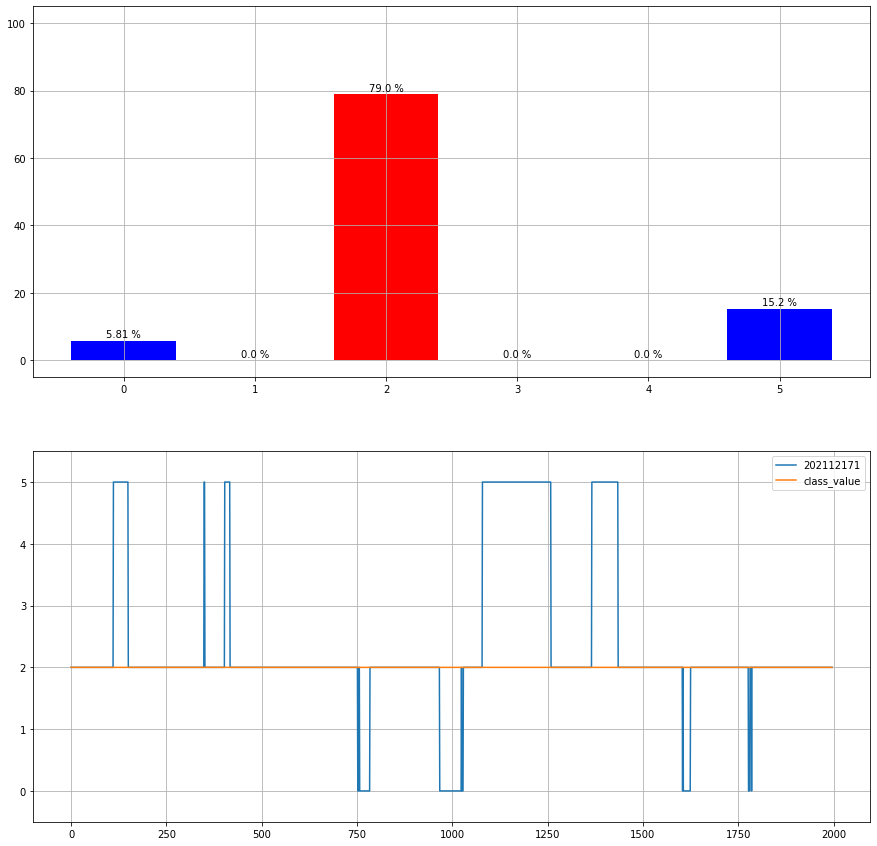

202201061
class value: 0


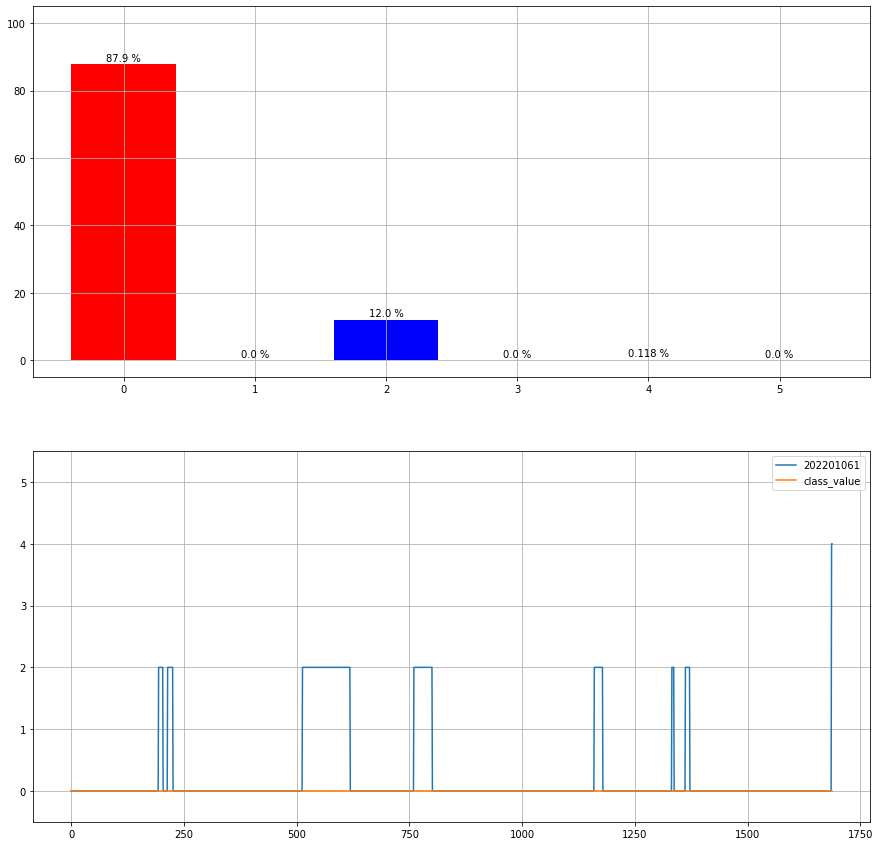

202201191
class value: 4


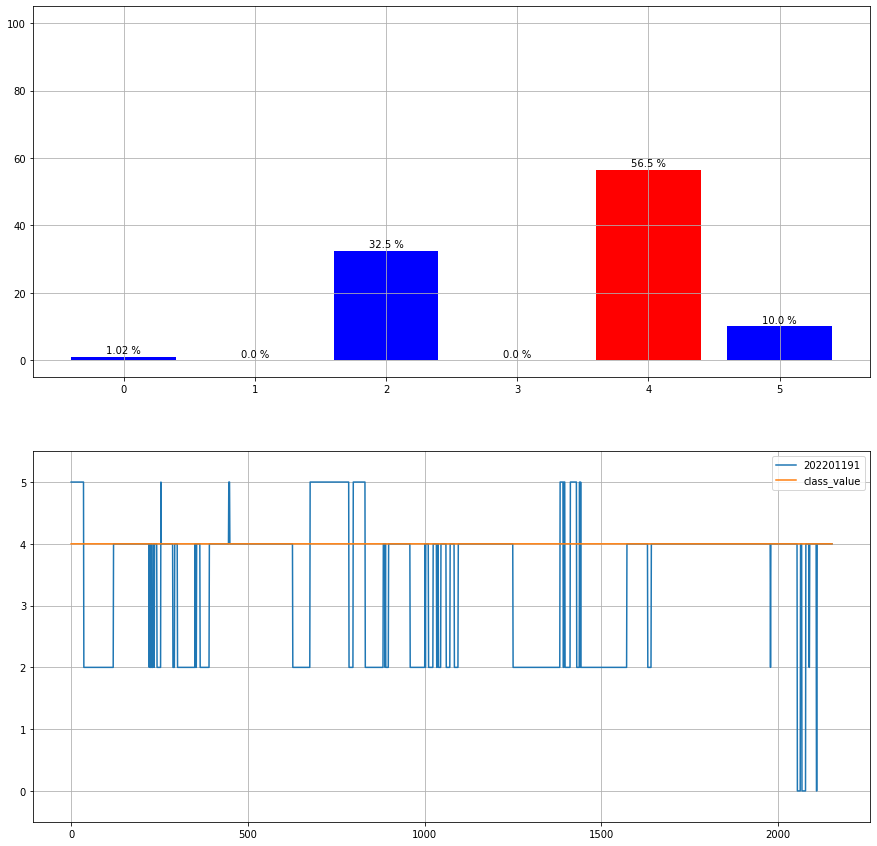

In [11]:
plt.ion()
for meas_name, pred_dict in result_dict.items():
    print(meas_name)
    print("class value: {}".format(pred_dict["class_value"]))
    
    pred_array = np.array(pred_dict["y_pred_list"]).argmax(axis=1)
    percentage_list = [len(pred_array[pred_array == value]) / len(pred_array) * 100 for value in range(6)]
    fig, axs = plt.subplots(2, 1)
    
    color_list = ['blue', 'blue', 'blue', 'blue', 'blue', 'blue']
    color_list[pred_dict["class_value"]] = "red"
    graph = axs[0].bar(list(range(6)),
               percentage_list,
               color=color_list)
    
    for p in graph:
        height = p.get_height()
        axs[0].text(x=p.get_x() + p.get_width() / 2, y=height+1,
        s="{:.3} %".format(height),
        ha='center')

    axs[0].set_ylim(-5, 105)
    axs[0].grid(True)
    
    axs[1].plot(np.array(pred_dict["y_pred_list"]).argmax(axis=1), label=meas_name)
    axs[1].plot([pred_dict["class_value"]] * len(pred_dict["y_pred_list"]), label="class_value")
    axs[1].axis([None, None, -0.5, 5.5])
    axs[1].legend(loc='best')
    axs[1].grid()
    os.makedirs("./plots_{}m_{}step/".format(int(length / (60 * 25)), step_size), exist_ok=True)
    plt.savefig("./plots_{}m_{}step/{}.png".format(int(length / (60 * 25)), step_size, meas_name))
    plt.show()

## Save to csv

### with probability

In [37]:
dict_to_df = dict()
max_length = 0

for k, v in result_dict.items():
    probs = np.array([x for x in v["y_pred_list"] if x is not None])

    for i, prob in enumerate(probs.T):
        dict_to_df[str(k) + "(" + str(v["class_value"]) + ")(" + str(i) + ")"] = prob.tolist()
        max_length = max(max_length, len(prob))

for l in dict_to_df.values():
    l += (max_length - len(l)) * [None]

result_df = pd.DataFrame.from_dict(dict_to_df)

length = 25 * 60 * 30
step_size = 500
result_df.to_csv("./result_prob_{}_{}.csv".format(length, step_size), index=False)

### with class values

In [7]:
dict_to_df = dict()
max_length = 0

for k, v in result_dict.items():
    probs = np.array([x for x in v["y_pred_list"] if x is not None])
    predicted_classes = probs.argmax(axis=1)

    dict_to_df[str(k) + "(" + str(v["class_value"]) + ")"] = predicted_classes.tolist()
    max_length = max(max_length, len(predicted_classes))

for l in dict_to_df.values():
    l += (max_length - len(l)) * [None]

result_df = pd.DataFrame.from_dict(dict_to_df)

length = 25 * 60 * 30
step_size = 500
result_df.to_csv("./result__class_{}_{}.csv".format(length, step_size), index=False)